In [2]:
import os

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns



In [3]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [4]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [5]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [6]:
proportions_list = np.arange(0.1, 1, 0.1)

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

for proportion in proportions_list:
    print(proportion)
    durations = []
    root_times = []
    relative_root_times = []

    diff = []
    moments = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        #print(scardec_name)
        momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type='fctmoy')

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)

        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        root_times.append(root_time)
        relative_root_times.append(root_time-start_time)

        if root_time-start_time > duration:
            print('root time greater than duration, proportion:', proportion)
            print(scardec_name)

    all_durations.append(durations)
    all_root_times.append(root_times)
    all_moments.append(moments)
    all_relative_root_times.append(relative_root_times)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9


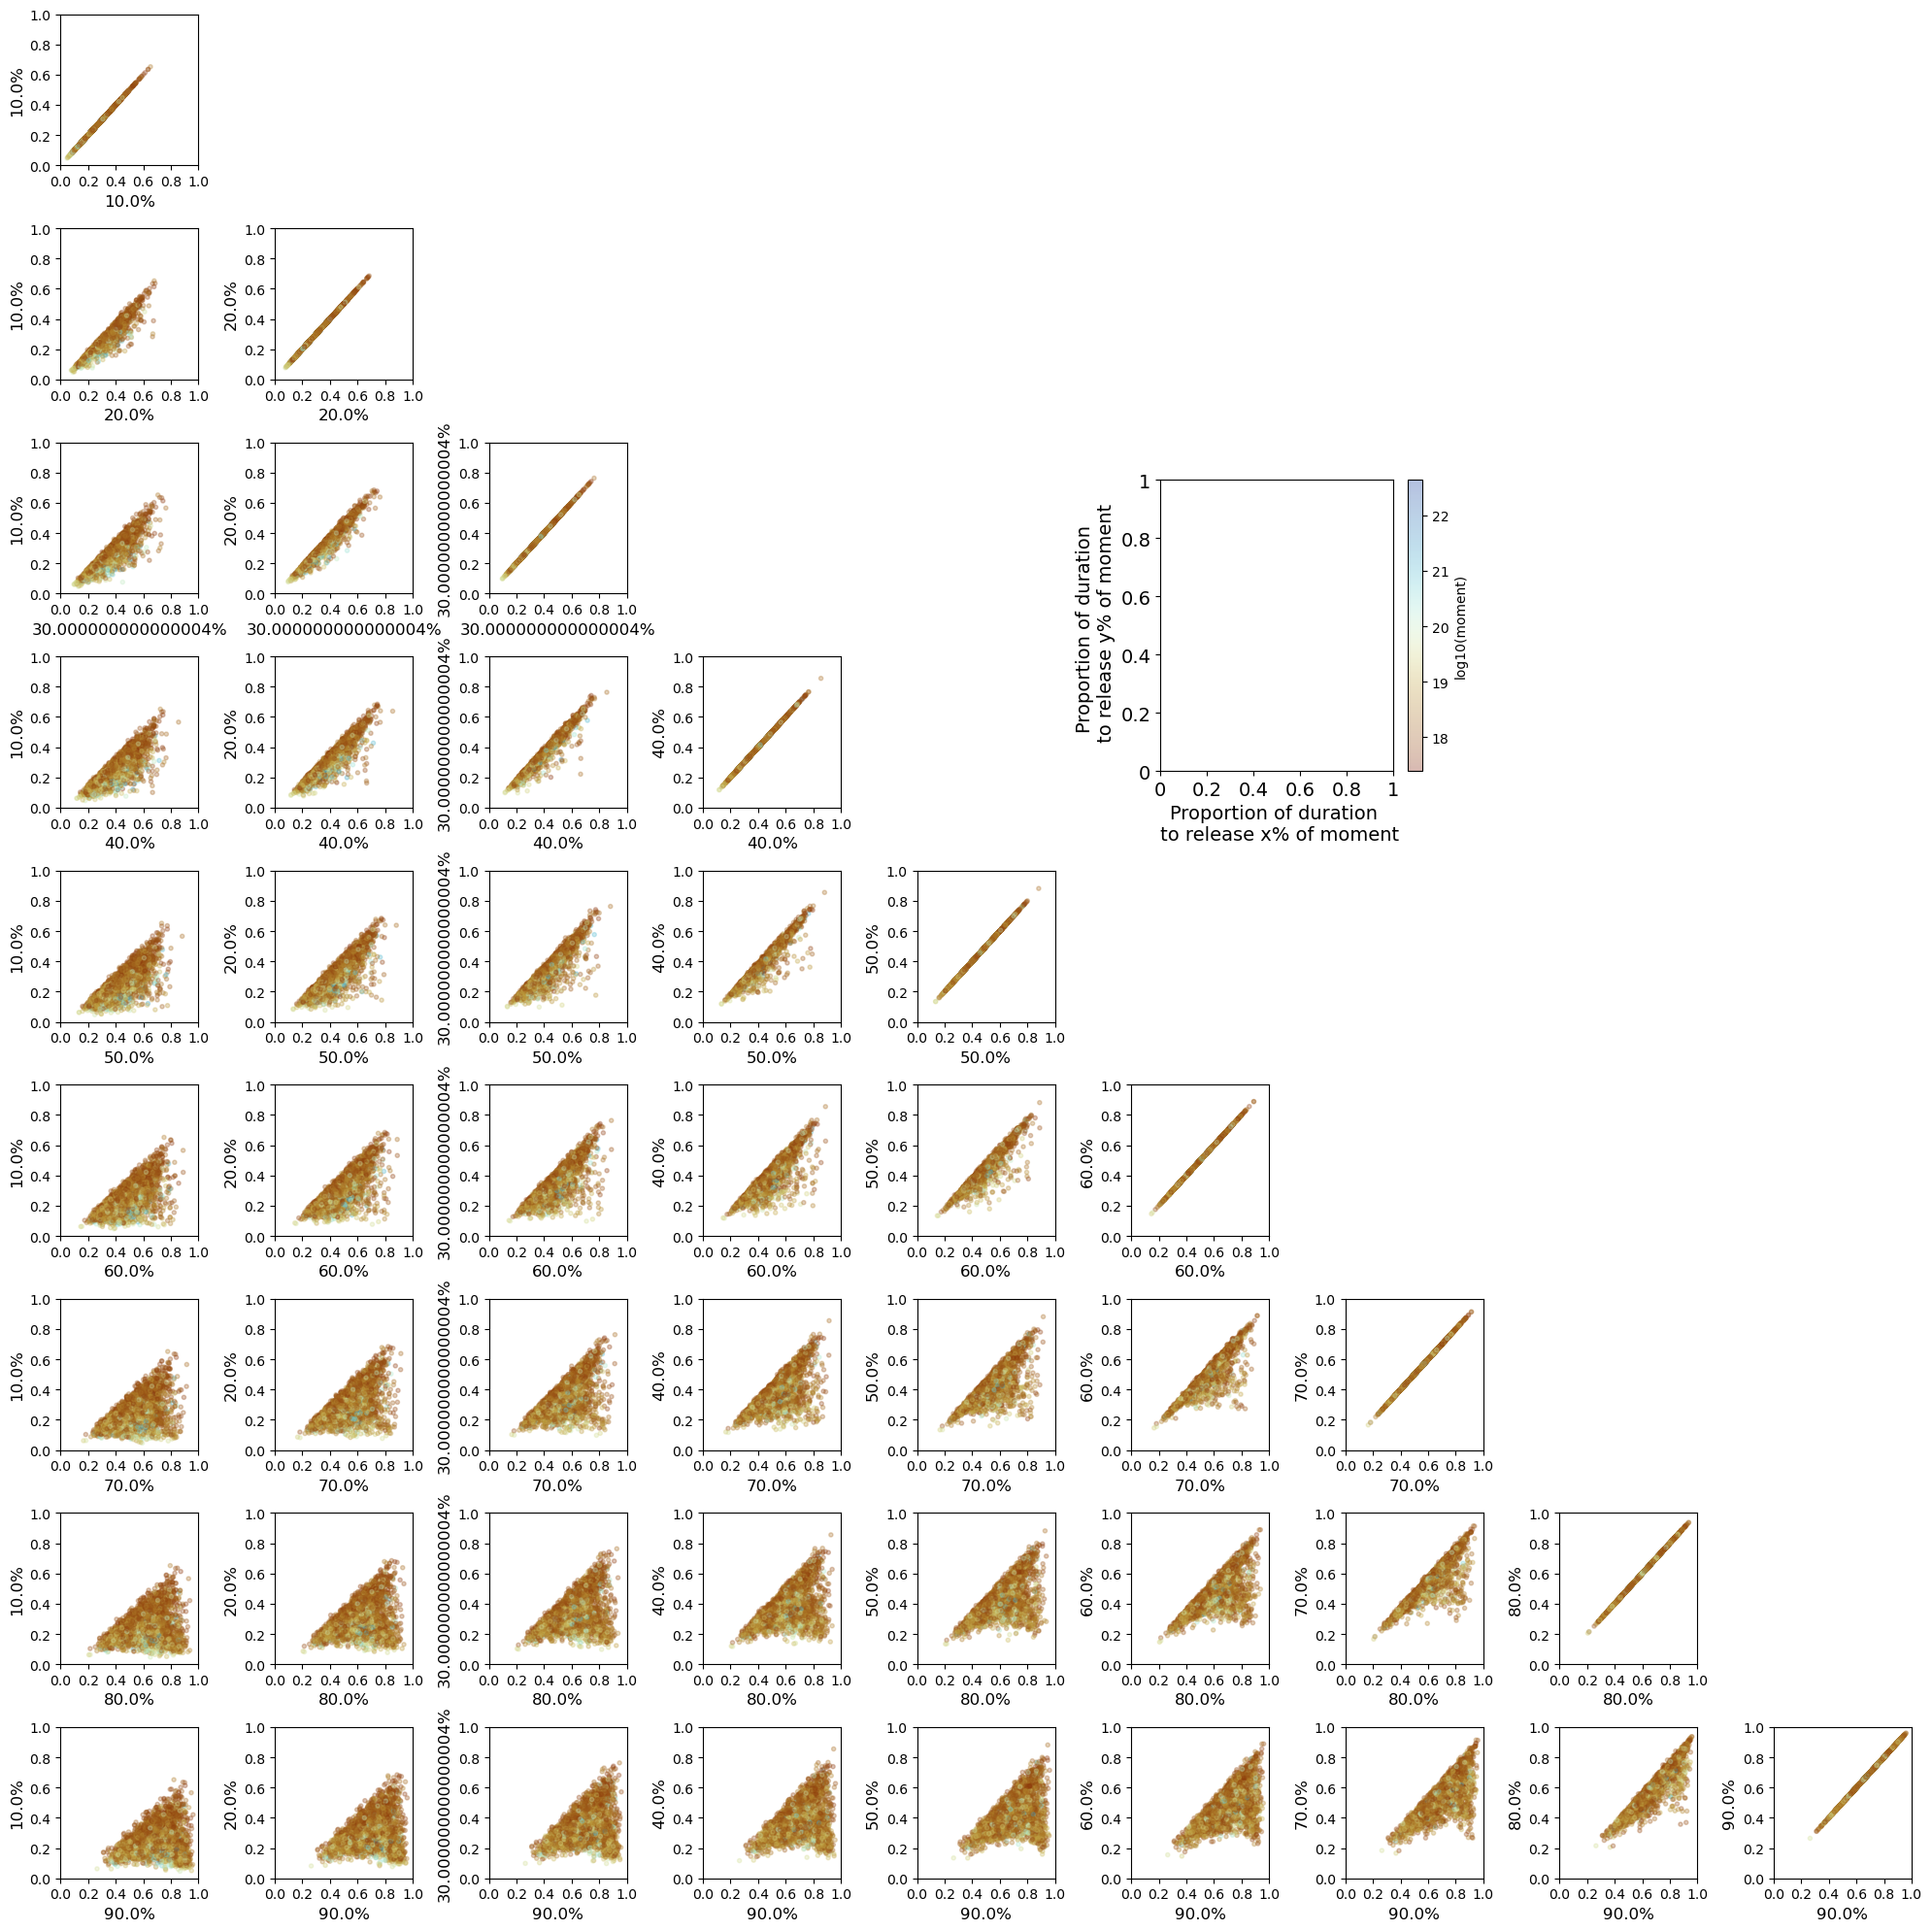

In [8]:
fig, axs = plt.subplots(len(proportions_list), len(proportions_list), figsize = (20,20))

proportions_list = np.array(proportions_list)
all_relative_root_times = np.array(all_relative_root_times)
all_durations = np.array(all_durations)
all_moments = np.array(all_moments)

for i, x_prop in enumerate(proportions_list):
    for j, y_prop in enumerate(proportions_list):
        if i >= j:
            sc = axs[i][j].scatter(all_relative_root_times[i]/all_durations[i],
                              all_relative_root_times[j]/all_durations[j],
                              alpha = 0.3,
                              marker = '.',
                              c = np.log10(all_moments[i]),
                              cmap = cmc.roma)
            axs[i][j].set_xlabel(f'{x_prop*100}%', fontsize = 12)
            axs[i][j].set_ylabel(f'{y_prop*100}%', fontsize = 12)
            axs[i][j].set_xlim(0, 1)
            axs[i][j].set_ylim(0, 1)
            axs[i][j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            axs[i][j].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        # elif i == 1 and j == len(proportions_list)-2:
        #     print(i, j)
        #     #axs[i][j].set_title('Proportion of duration to release moment')

        else:
            axs[i][j].axis('off')

plt.tight_layout()
left, bottom, width, height = [0.6, 0.6, 0.15, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.set_xlabel('Proportion of duration \n to release x% of moment', fontsize = 14)
ax2.set_ylabel('Proportion of duration \n to release y% of moment', fontsize = 14)

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)

fig.colorbar(sc, ax = ax2, label = 'log10(moment)', orientation = 'vertical')

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/moment_intervals_comparisons/relative_root_times.png')

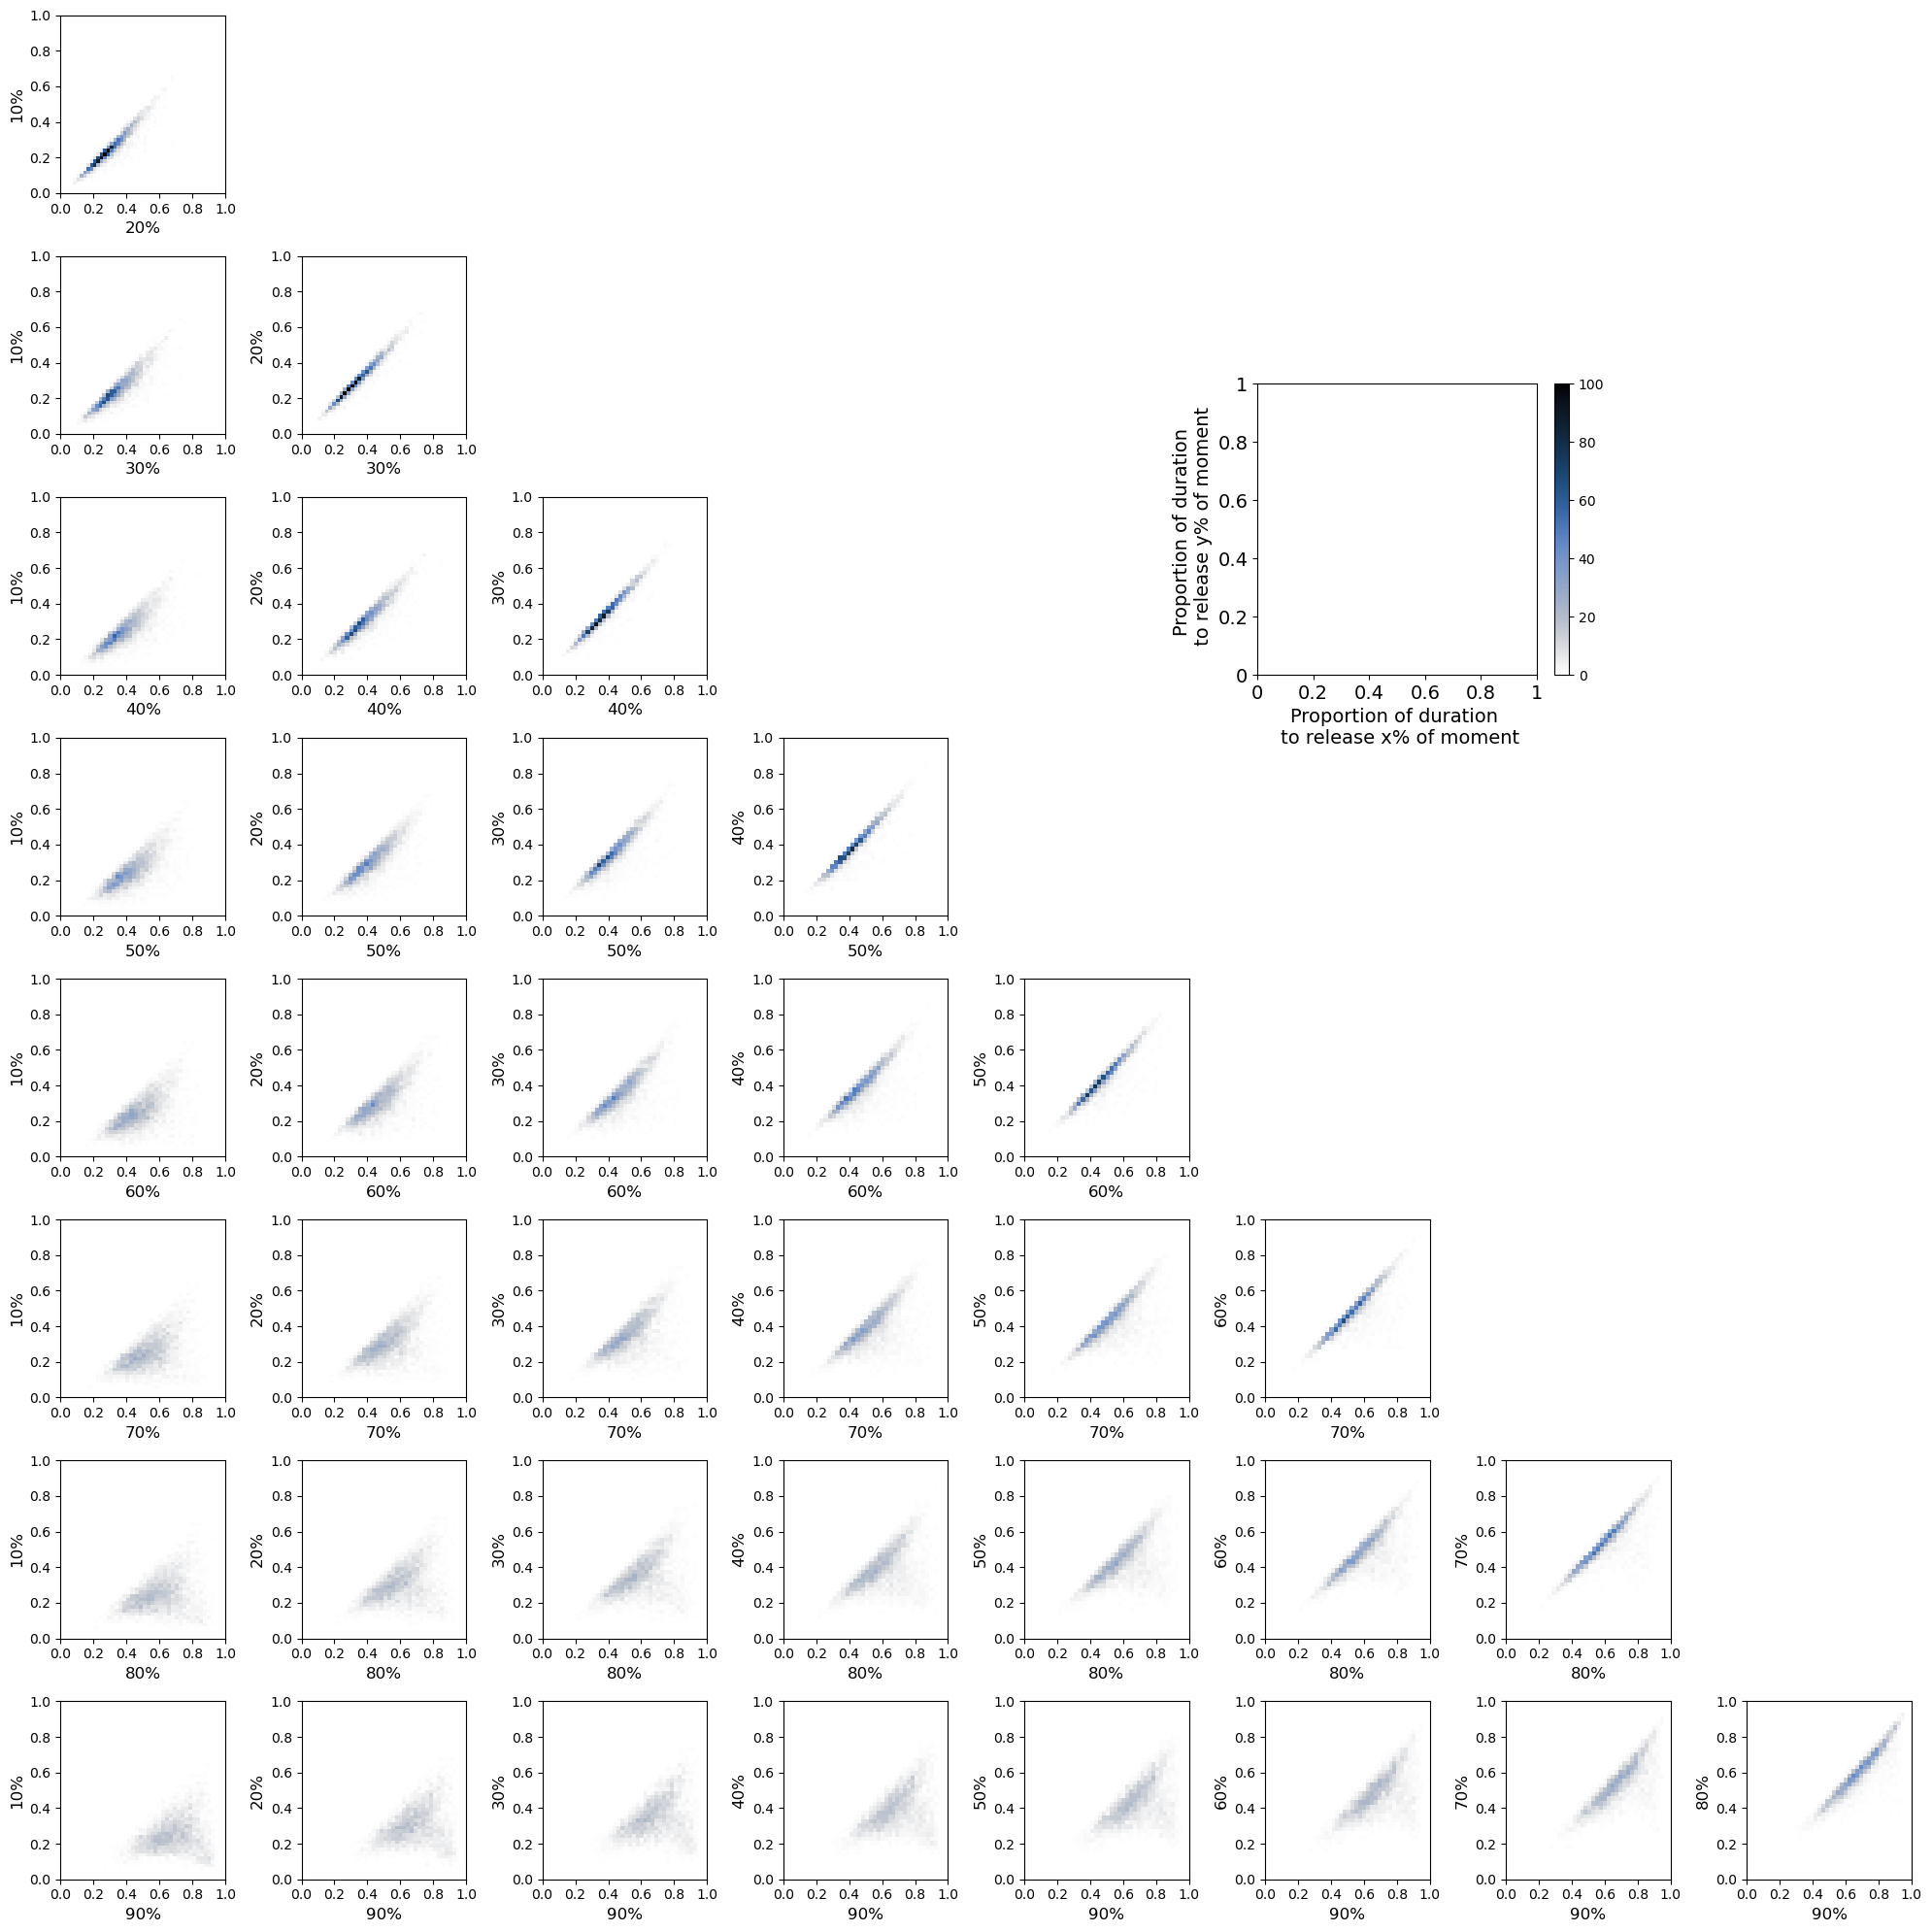

In [9]:
fig, axs = plt.subplots(len(proportions_list)-1, len(proportions_list)-1, figsize = (20,20))

proportions_list = np.array(proportions_list)
all_relative_root_times = np.array(all_relative_root_times)
all_durations = np.array(all_durations)

for a in range(1, len(proportions_list)): #, x_prop in enumerate(proportions_list):
    for b in range(0, len(proportions_list)):#, y_prop in enumerate(proportions_list):
        if b < len(proportions_list)-1:
            axs[a-1][b].set_xlabel(f'{a},{b}', fontsize = 12)
            x_prop = proportions_list[a]
            y_prop = proportions_list[b]
            if a != b:
                if a-1 >= b:
                    axs[a-1][b].scatter([0.5],[0.5], color = 'red')
                    h = axs[a-1][b].hist2d(all_relative_root_times[a]/all_durations[a],
                                    all_relative_root_times[b]/all_durations[b],
                                    cmap = cmc.oslo_r,
                                    density=True,
                                    bins = 30,
                                    vmin = 0,
                                    vmax = 100)
                    #axs[i][j].scatter(all_relative_root_times[i]/all_durations[i], all_relative_root_times[j]/all_durations[j], alpha = 0.3, marker = '.')
                    #axs[i][j].set_xlabel(f'{a-1},{b},{x_prop*100}%', fontsize = 12)
                    axs[a-1][b].set_ylabel(f'{y_prop*100:.0f}%', fontsize = 12)
                    axs[a-1][b].set_xlabel(f'{x_prop*100:.0f}%', fontsize = 12)
                    axs[a-1][b].set_xlim(0, 1)
                    axs[a-1][b].set_ylim(0, 1)
                    axs[a-1][b].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                    axs[a-1][b].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                else:
                    axs[a-1][b].axis('off')
                    #axs[a-1][b].scatter([0.5],[0.5], color = 'blue', marker = 'x', s = 100)
            else:
                #axs[a-1][b].scatter([0.5],[0.5], color = 'blue', marker = '^', s = 100)
                axs[a-1][b].axis('off')


plt.tight_layout()
left, bottom, width, height = [0.65, 0.65, 0.18, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.set_xlabel('Proportion of duration \n to release x% of moment', fontsize = 14)
ax2.set_ylabel('Proportion of duration \n to release y% of moment', fontsize = 14)

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)

fig.colorbar(h[3], ax = ax2)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/moment_intervals_comparisons/relative_root_times_heatmap_no_diagonal.png')

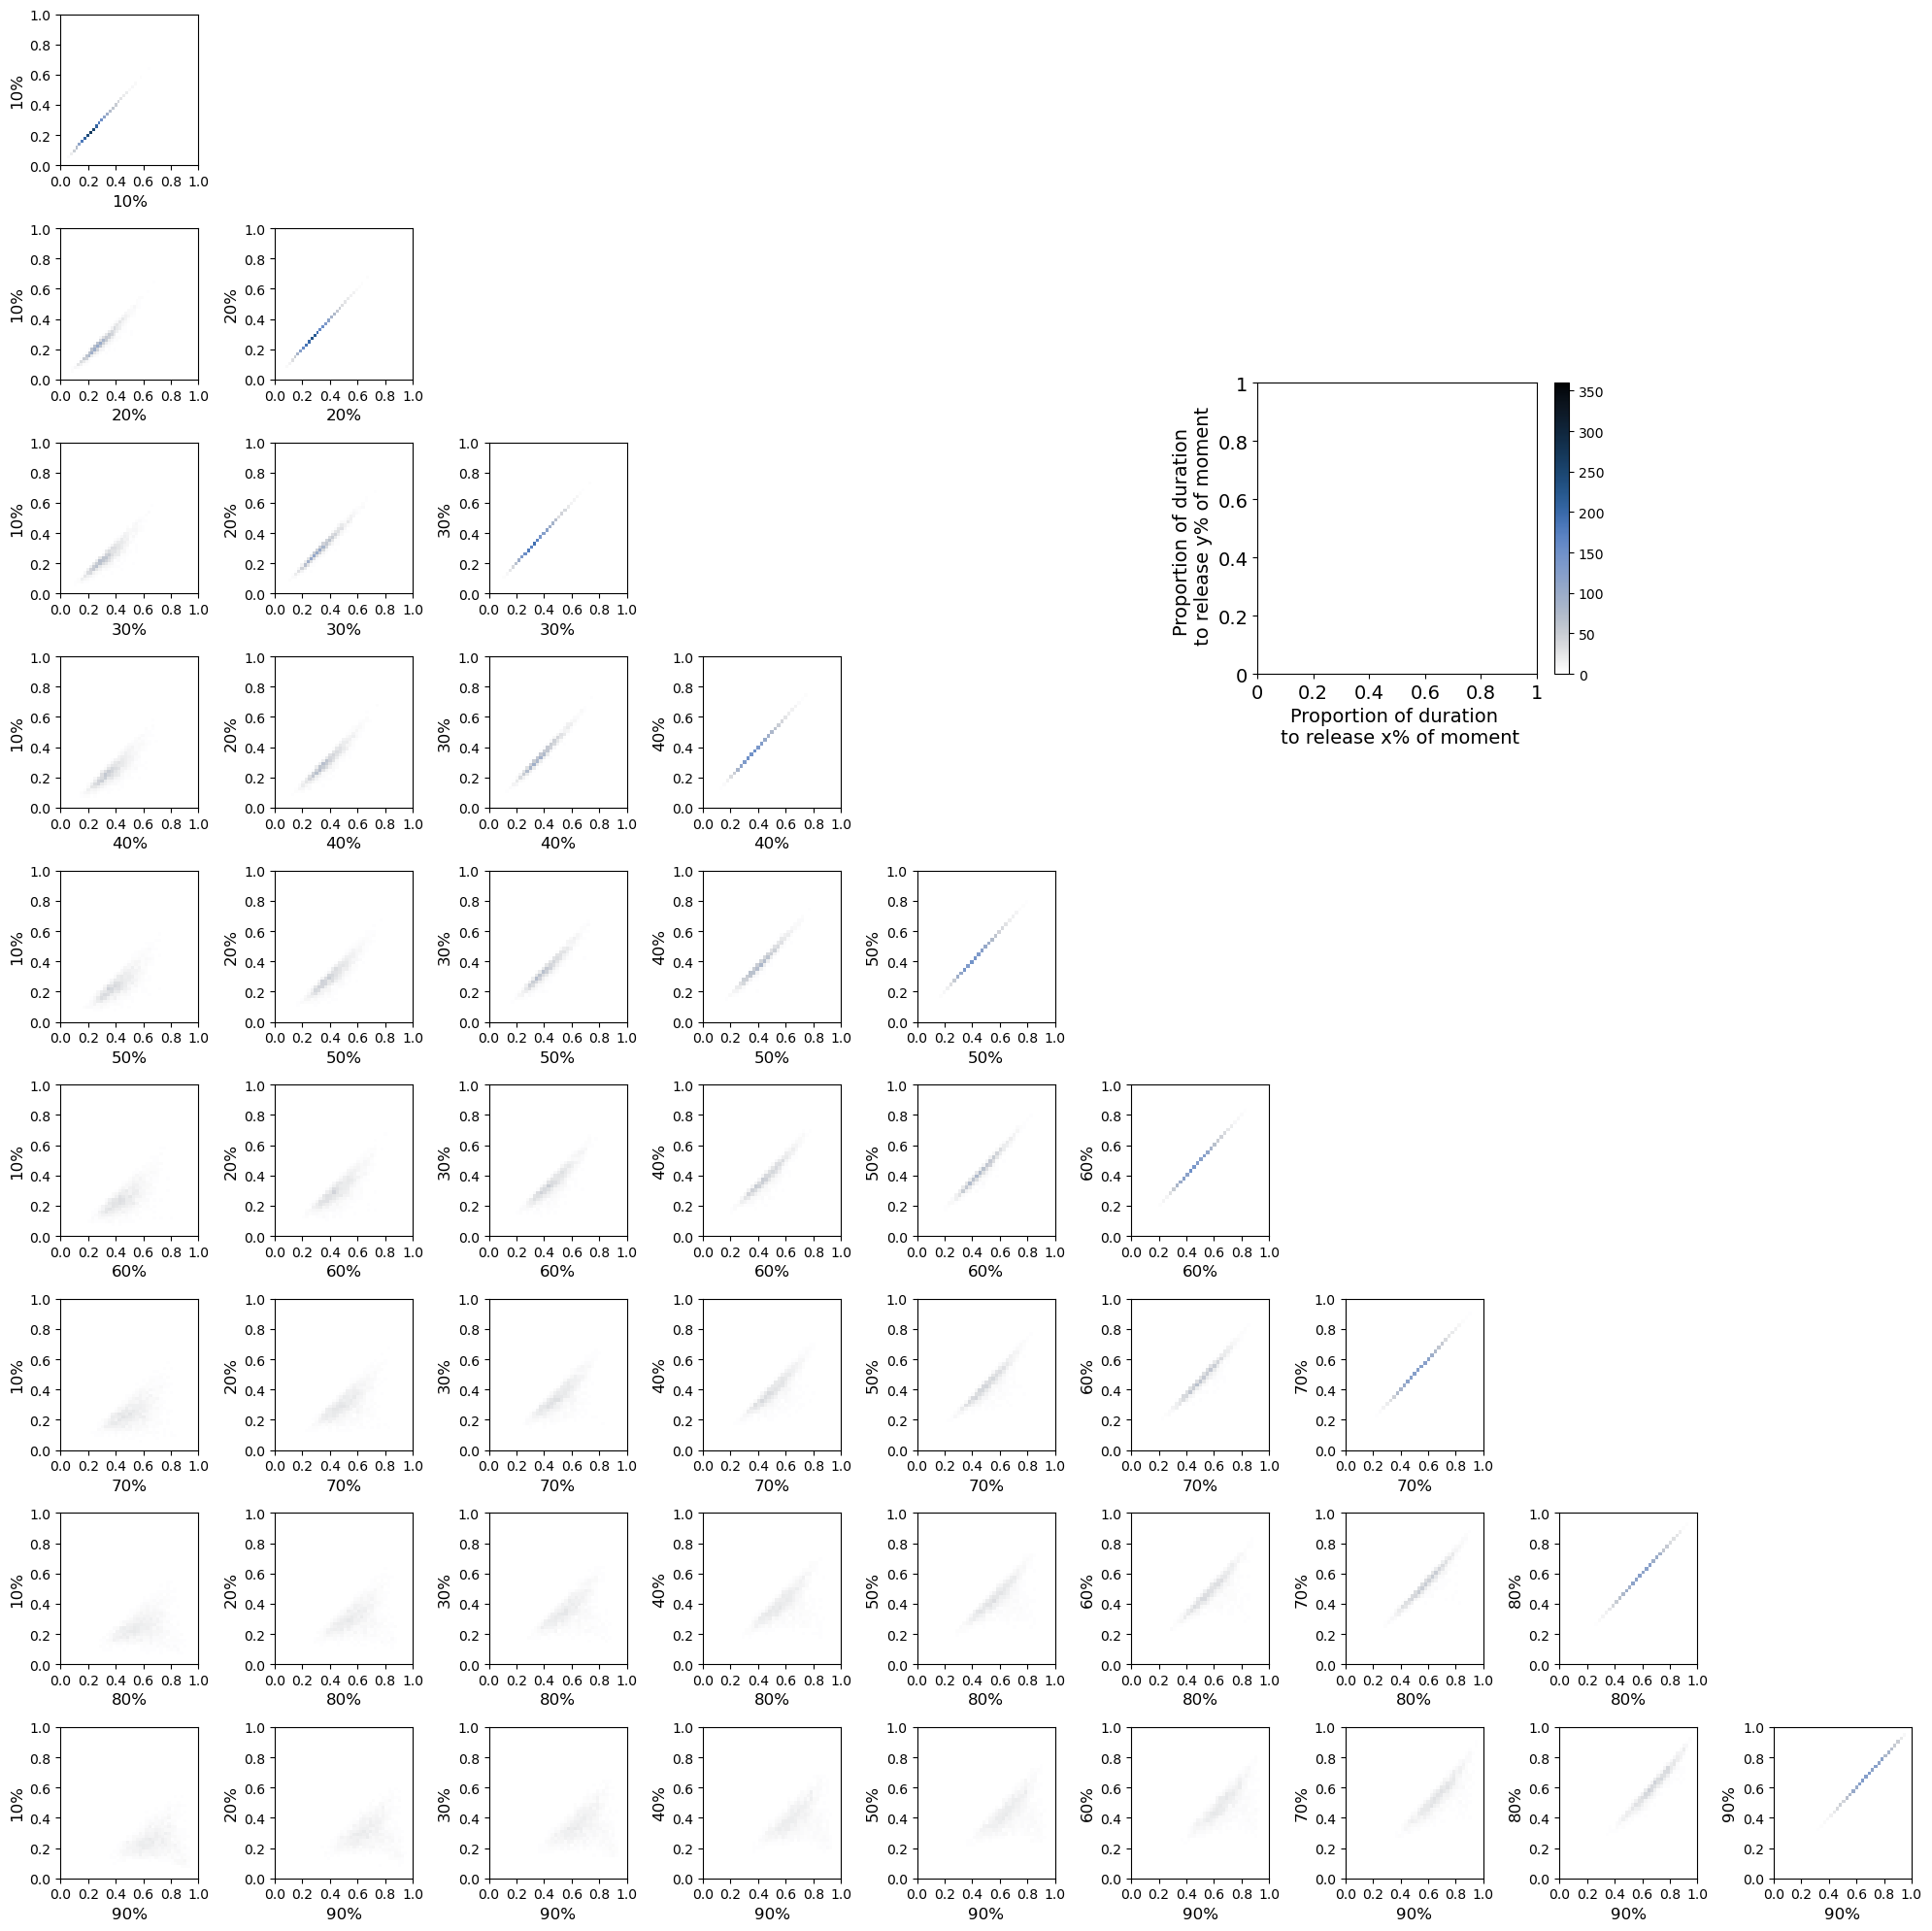

In [10]:
fig, axs = plt.subplots(len(proportions_list), len(proportions_list), figsize = (20,20))

proportions_list = np.array(proportions_list)
all_relative_root_times = np.array(all_relative_root_times)
all_durations = np.array(all_durations)

for a in range(0, len(proportions_list)): #, x_prop in enumerate(proportions_list):
    for b in range(0, len(proportions_list)):#, y_prop in enumerate(proportions_list):
        axs[a][b].set_xlabel(f'{a},{b}', fontsize = 12)
        x_prop = proportions_list[a]
        y_prop = proportions_list[b]
        if a >= b:
            axs[a][b].scatter([0.5],[0.5], color = 'red')
            h = axs[a][b].hist2d(all_relative_root_times[a]/all_durations[a],
                            all_relative_root_times[b]/all_durations[b],
                            cmap = cmc.oslo_r,
                            density=True,
                            bins = 30,
                            vmin = 0,
                            vmax = 360)
            #axs[i][j].scatter(all_relative_root_times[i]/all_durations[i], all_relative_root_times[j]/all_durations[j], alpha = 0.3, marker = '.')
            #axs[i][j].set_xlabel(f'{a-1},{b},{x_prop*100}%', fontsize = 12)
            axs[a][b].set_ylabel(f'{y_prop*100:.0f}%', fontsize = 12)
            axs[a][b].set_xlabel(f'{x_prop*100:.0f}%', fontsize = 12)
            axs[a][b].set_xlim(0, 1)
            axs[a][b].set_ylim(0, 1)
            axs[a][b].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            axs[a][b].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        else:
            axs[a][b].axis('off')
            #axs[a][b].scatter([0.5],[0.5], color = 'blue', marker = 'x', s = 100)



plt.tight_layout()
left, bottom, width, height = [0.65, 0.65, 0.18, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.set_xlabel('Proportion of duration \n to release x% of moment', fontsize = 14)
ax2.set_ylabel('Proportion of duration \n to release y% of moment', fontsize = 14)

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)

fig.colorbar(h[3], ax = ax2)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/moment_intervals_comparisons/relative_root_times_heatmap.png')

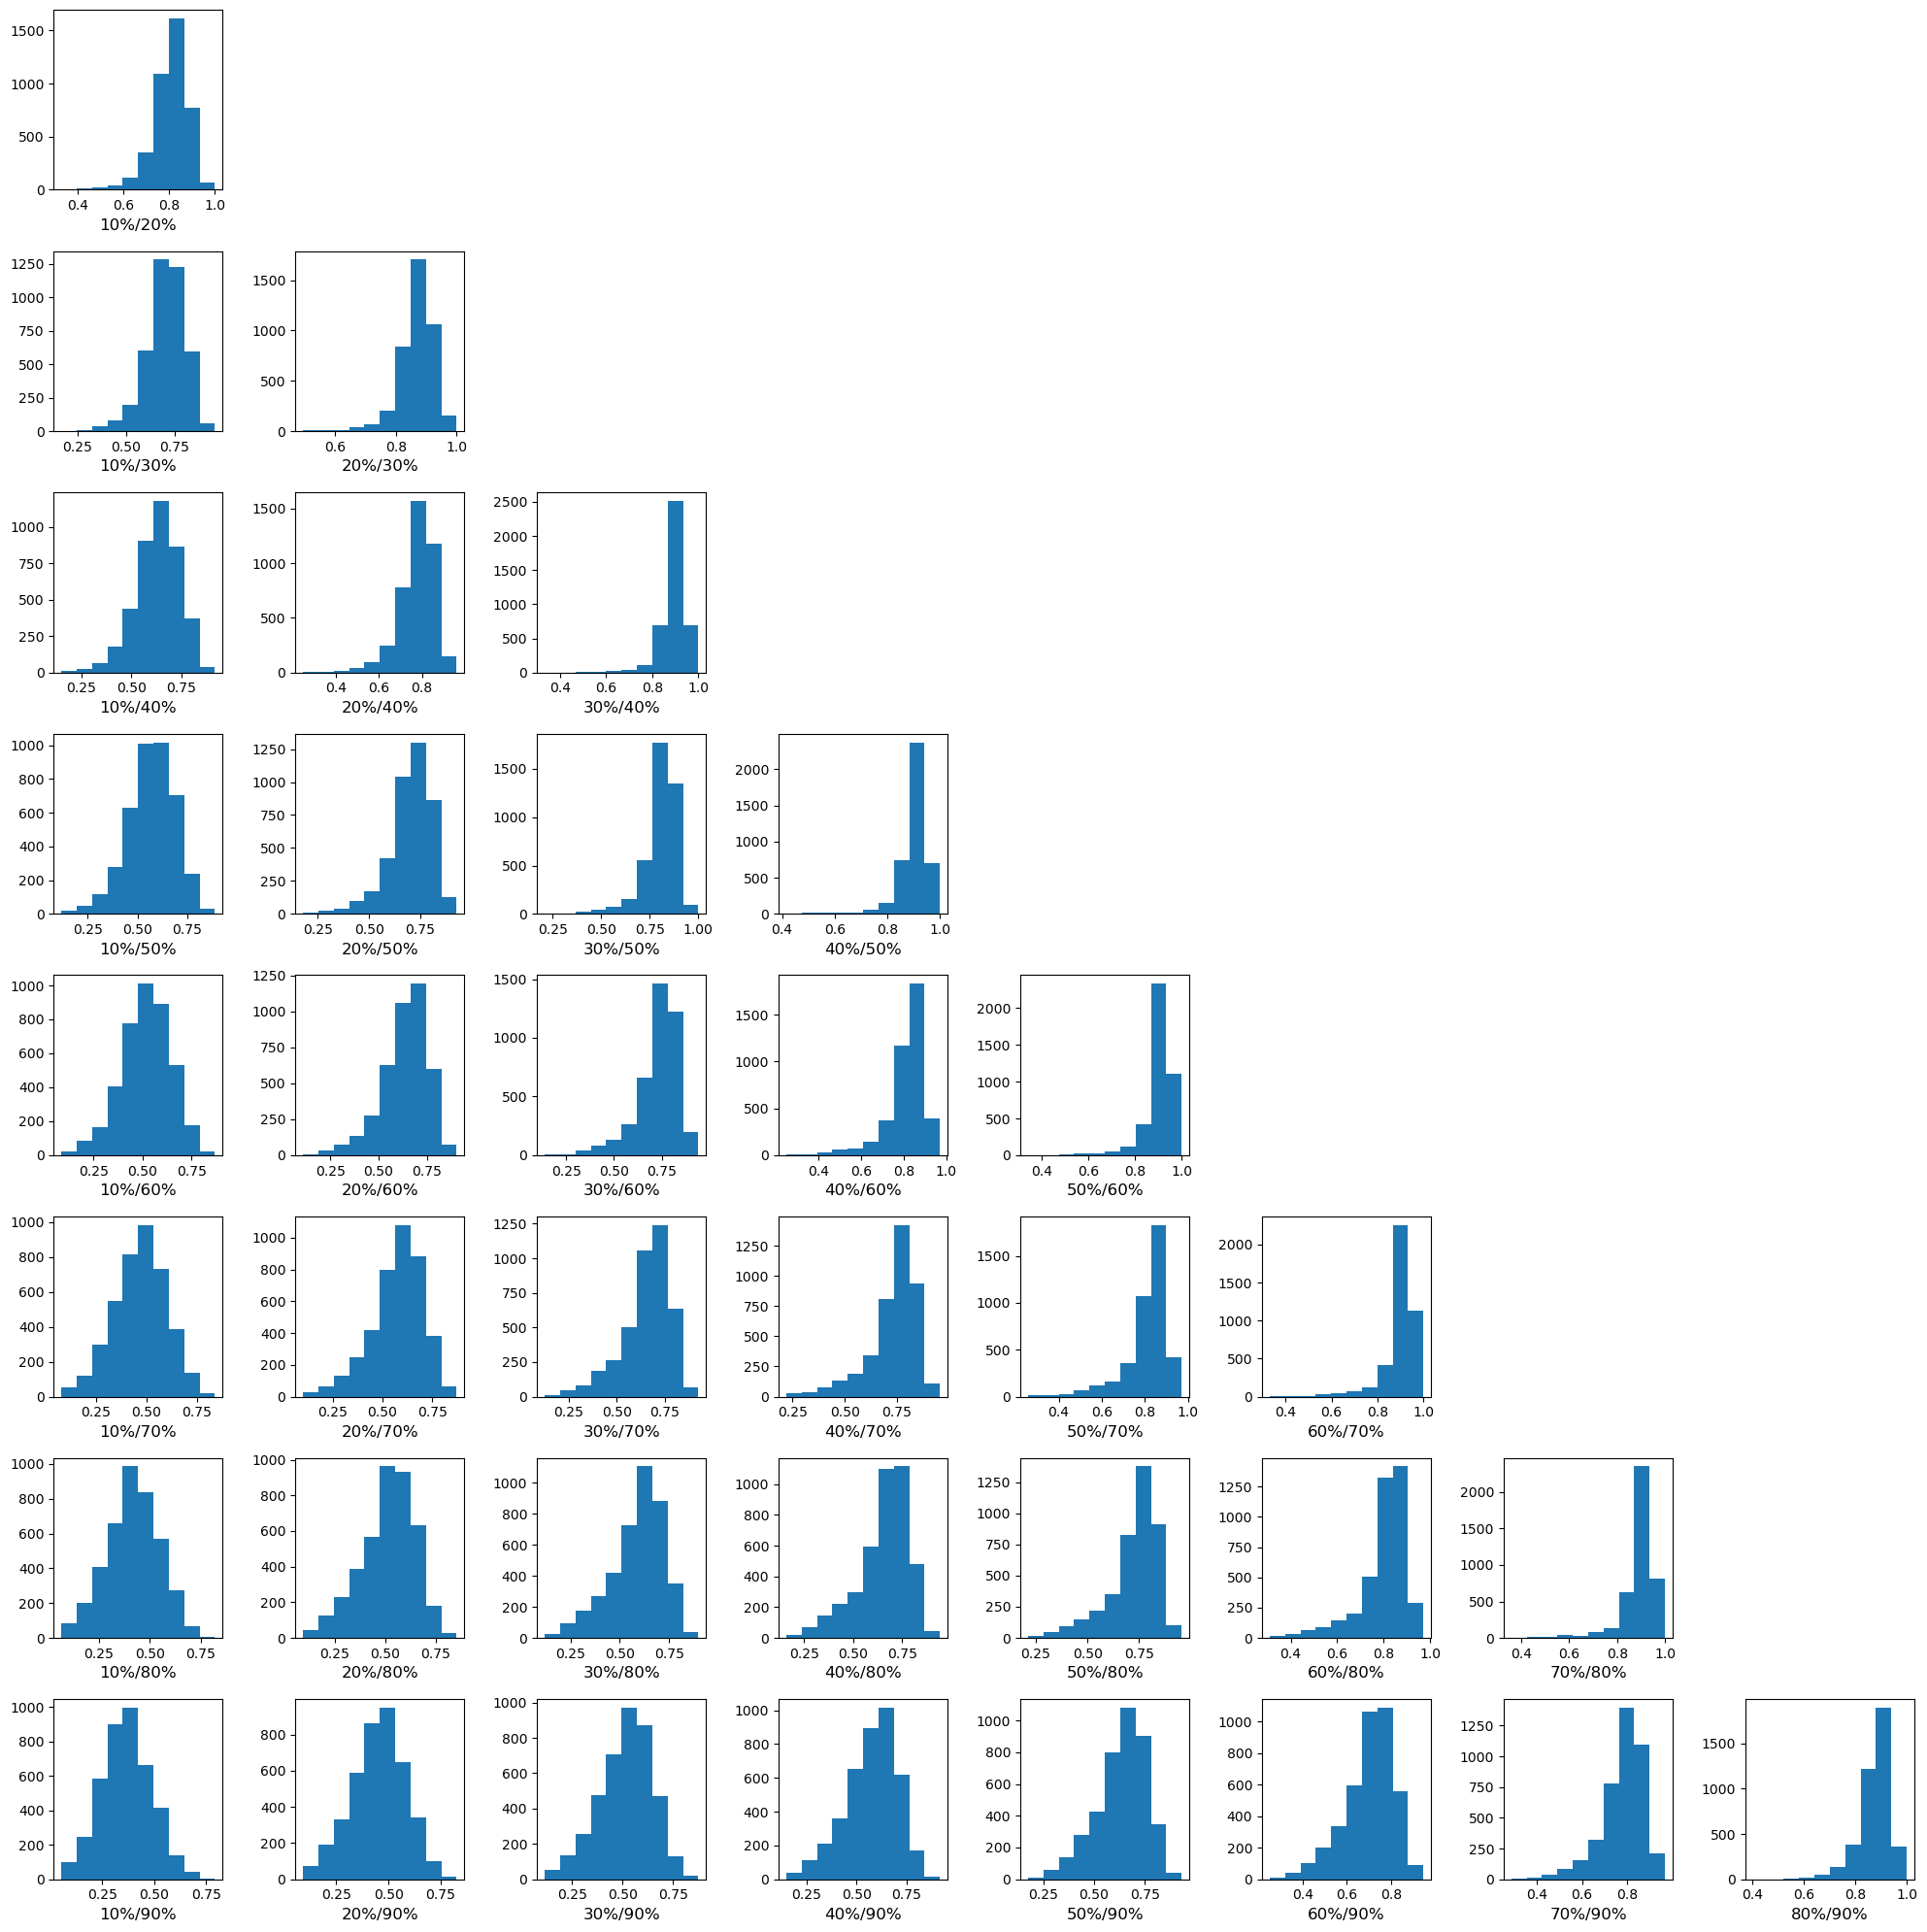

In [11]:
fig, axs = plt.subplots(len(proportions_list)-1, len(proportions_list)-1, figsize = (20,20))

proportions_list = np.array(proportions_list)
all_relative_root_times = np.array(all_relative_root_times)
all_durations = np.array(all_durations)

for a in range(1, len(proportions_list)): #, x_prop in enumerate(proportions_list):
    for b in range(0, len(proportions_list)):#, y_prop in enumerate(proportions_list):
        if b < len(proportions_list)-1:

            x_prop = proportions_list[a]
            y_prop = proportions_list[b]
            if a != b:
                if a-1 >= b:
                    axs[a-1][b].hist((all_relative_root_times[b]/all_durations[b])/(all_relative_root_times[a]/all_durations[a]))
                    axs[a-1][b].set_xlabel(f'{y_prop*100:.0f}%/{x_prop*100:.0f}%', fontsize = 12)
                else:
                    axs[a-1][b].axis('off')
                    #axs[a-1][b].scatter([0.5],[0.5], color = 'blue', marker = 'x', s = 100)
            else:
                #axs[a-1][b].scatter([0.5],[0.5], color = 'blue', marker = '^', s = 100)
                axs[a-1][b].axis('off')

plt.tight_layout()
#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals_comparisons/relative_root_times_heatmap_no_diagonal.png')

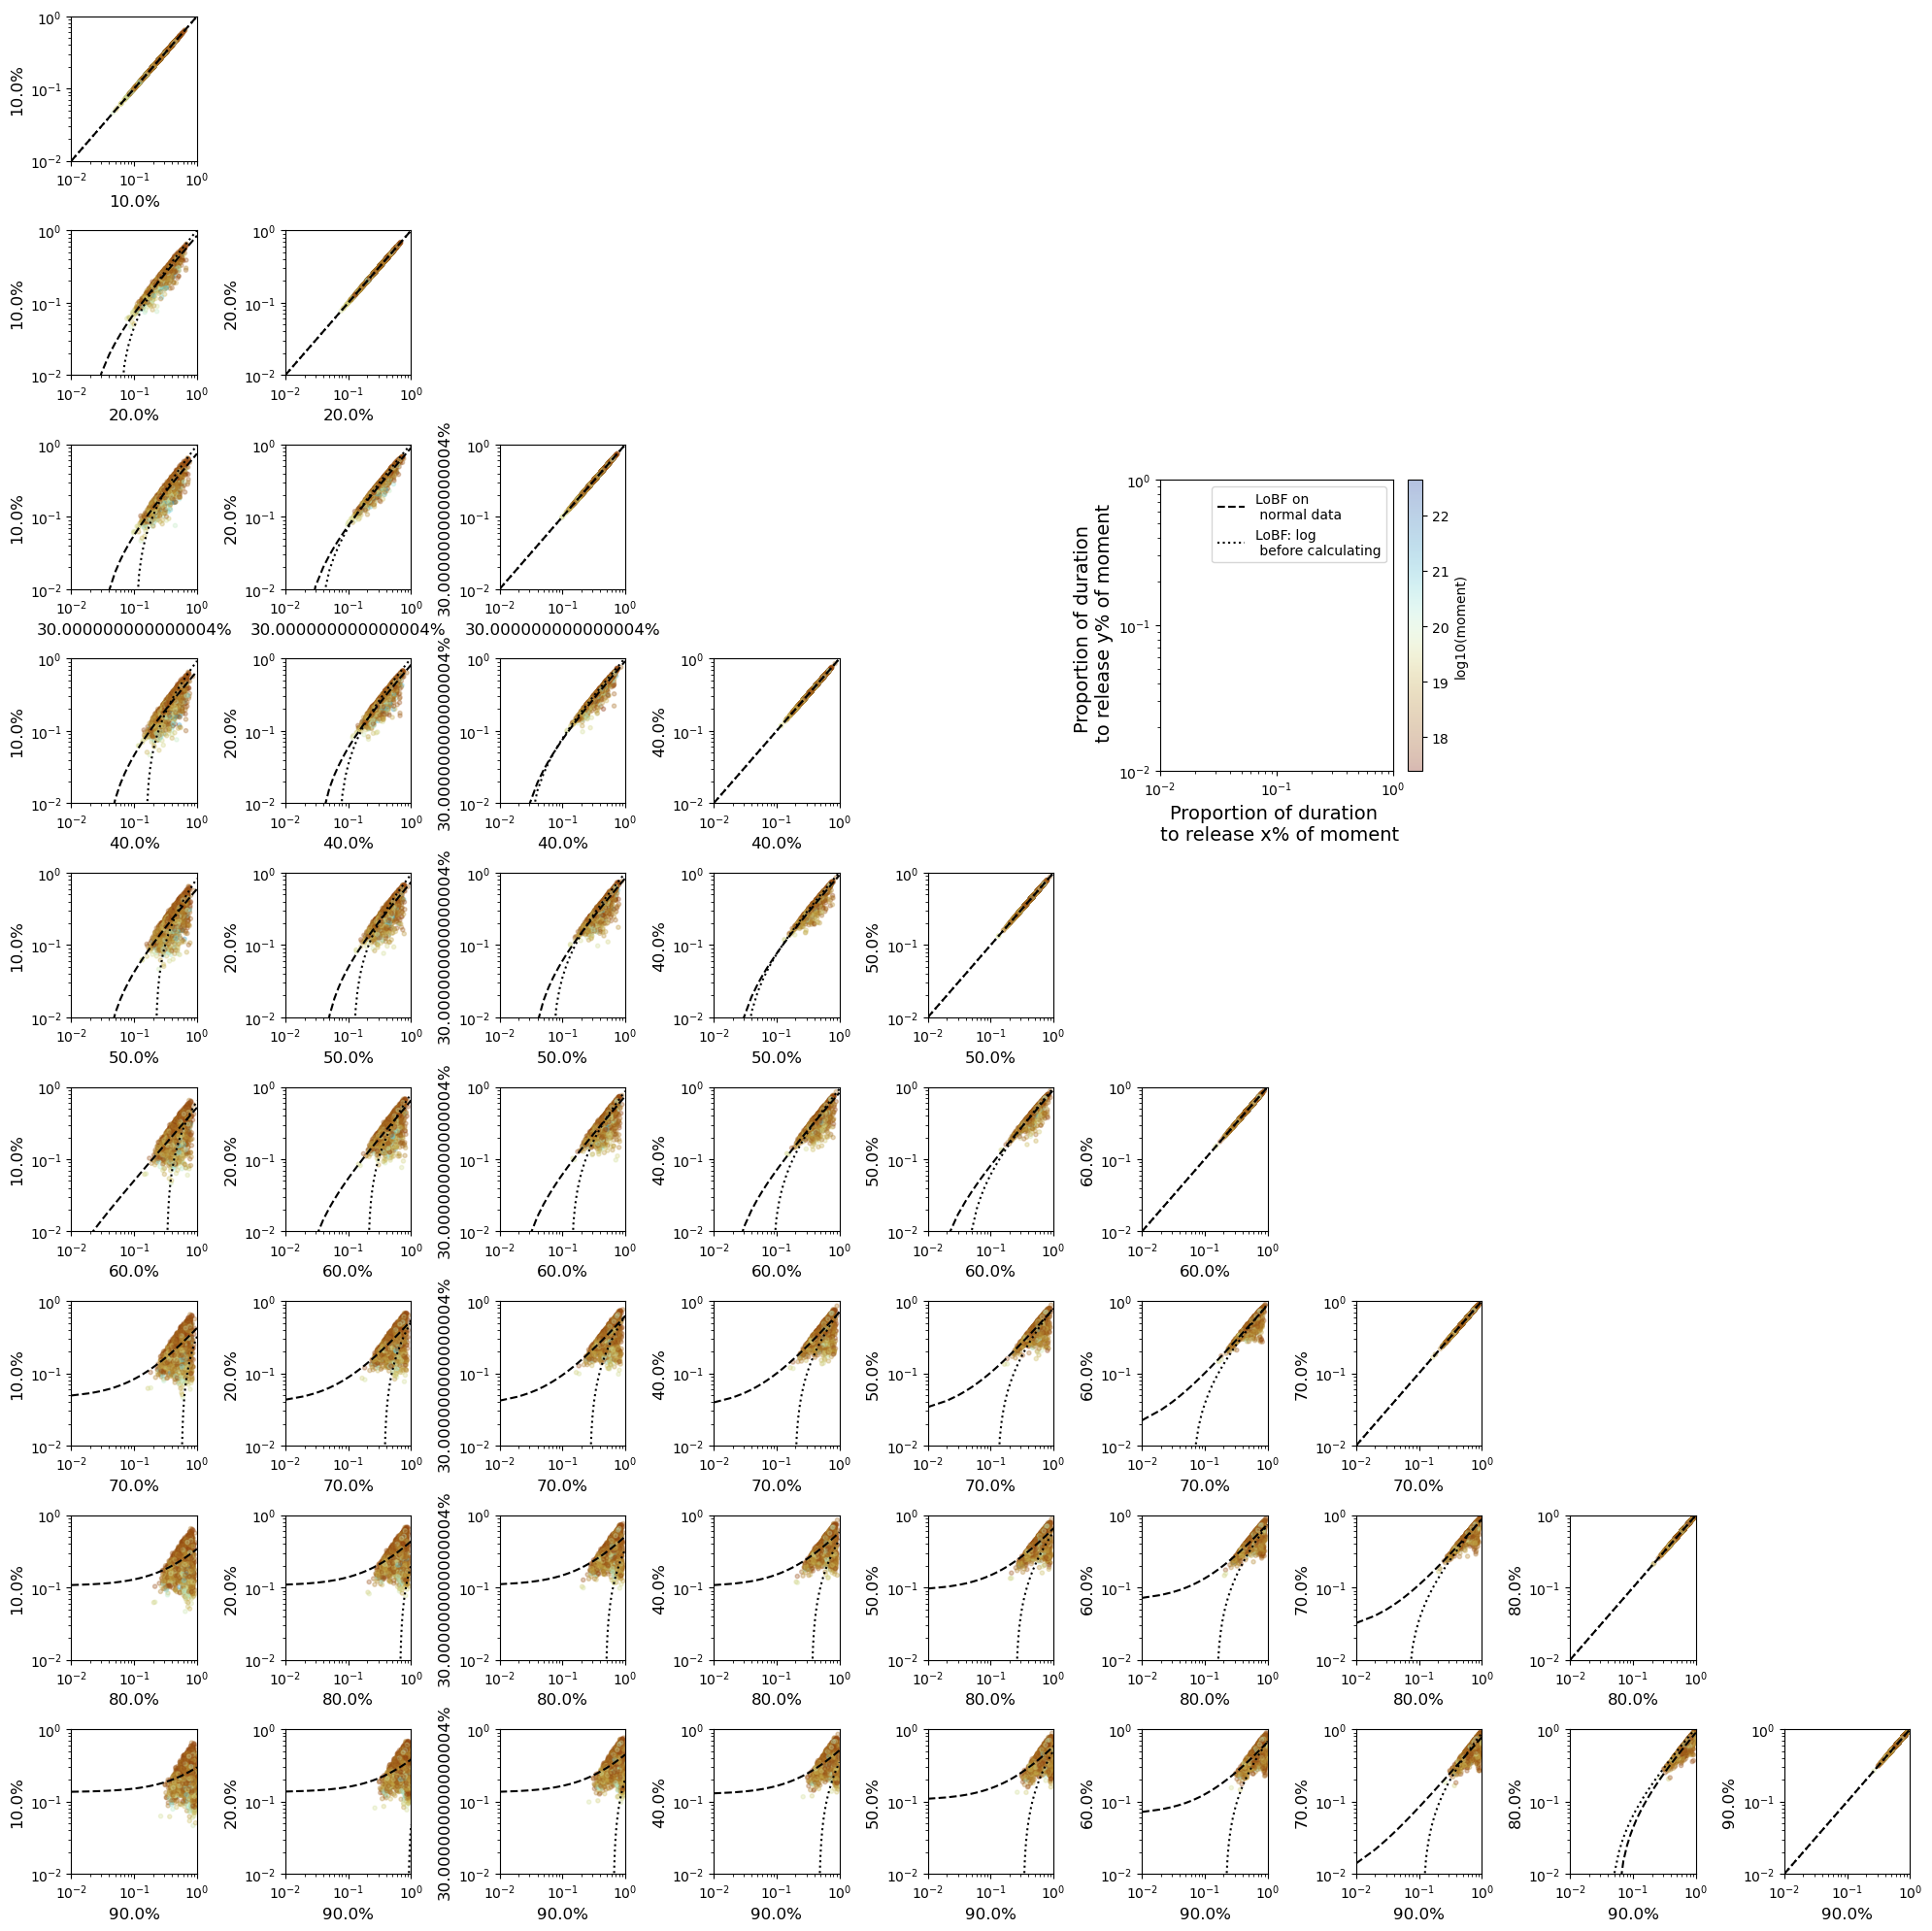

In [12]:
fig, axs = plt.subplots(len(proportions_list), len(proportions_list), figsize = (20,20))

proportions_list = np.array(proportions_list)
all_relative_root_times = np.array(all_relative_root_times)
all_durations = np.array(all_durations)
all_moments = np.array(all_moments)

for i, x_prop in enumerate(proportions_list):
    for j, y_prop in enumerate(proportions_list):
        if i >= j:
            sc = axs[i][j].scatter(all_relative_root_times[i]/all_durations[i],
                              all_relative_root_times[j]/all_durations[j],
                              alpha = 0.3,
                              marker = '.',
                              c = np.log10(all_moments[i]),
                              cmap = cmc.roma)
            axs[i][j].set_xlabel(f'{x_prop*100}%', fontsize = 12)
            axs[i][j].set_ylabel(f'{y_prop*100}%', fontsize = 12)

            # axs[i][j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            # axs[i][j].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            axs[i][j].set_yscale('log')
            axs[i][j].set_xscale('log')
            axs[i][j].set_xlim(1E-02, 1)
            axs[i][j].set_ylim(1E-02, 1)

            a, b = np.polyfit(all_relative_root_times[i]/all_durations[i],
                              all_relative_root_times[j]/all_durations[j],
                              1) # fit a line to the data

            x = np.linspace(1E-02, 1, 100)
            y = a*x + b

            axs[i][j].plot(x, y, color = 'black', linestyle = '--')

            a, b = np.polyfit(np.log10(all_relative_root_times[i]/all_durations[i]),
                              np.log10(all_relative_root_times[j]/all_durations[j]),
                              1) # fit a line to the data

            x = np.linspace(1E-02, 1, 100)
            y = a*x + b

            axs[i][j].plot(x, y, color = 'black', linestyle = ':')



        # elif i == 1 and j == len(proportions_list)-2:
        #     print(i, j)
        #     #axs[i][j].set_title('Proportion of duration to release moment')

        else:
            axs[i][j].axis('off')

plt.tight_layout()
left, bottom, width, height = [0.6, 0.6, 0.15, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.set_xlabel('Proportion of duration \n to release x% of moment', fontsize = 14)
ax2.set_ylabel('Proportion of duration \n to release y% of moment', fontsize = 14)

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlim(1E-02, 1)
ax2.set_ylim(1E-02, 1)

ax2.plot([], [], color = 'black', linestyle = '--', label = 'LoBF on \n normal data')

ax2.plot([], [], color = 'black', linestyle = ':', label = 'LoBF: log \n before calculating')

ax2.legend()
fig.colorbar(sc, ax = ax2, label = 'log10(moment)', orientation = 'vertical')

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/moment_intervals_comparisons/relative_root_times_log_log_LoBF.png')

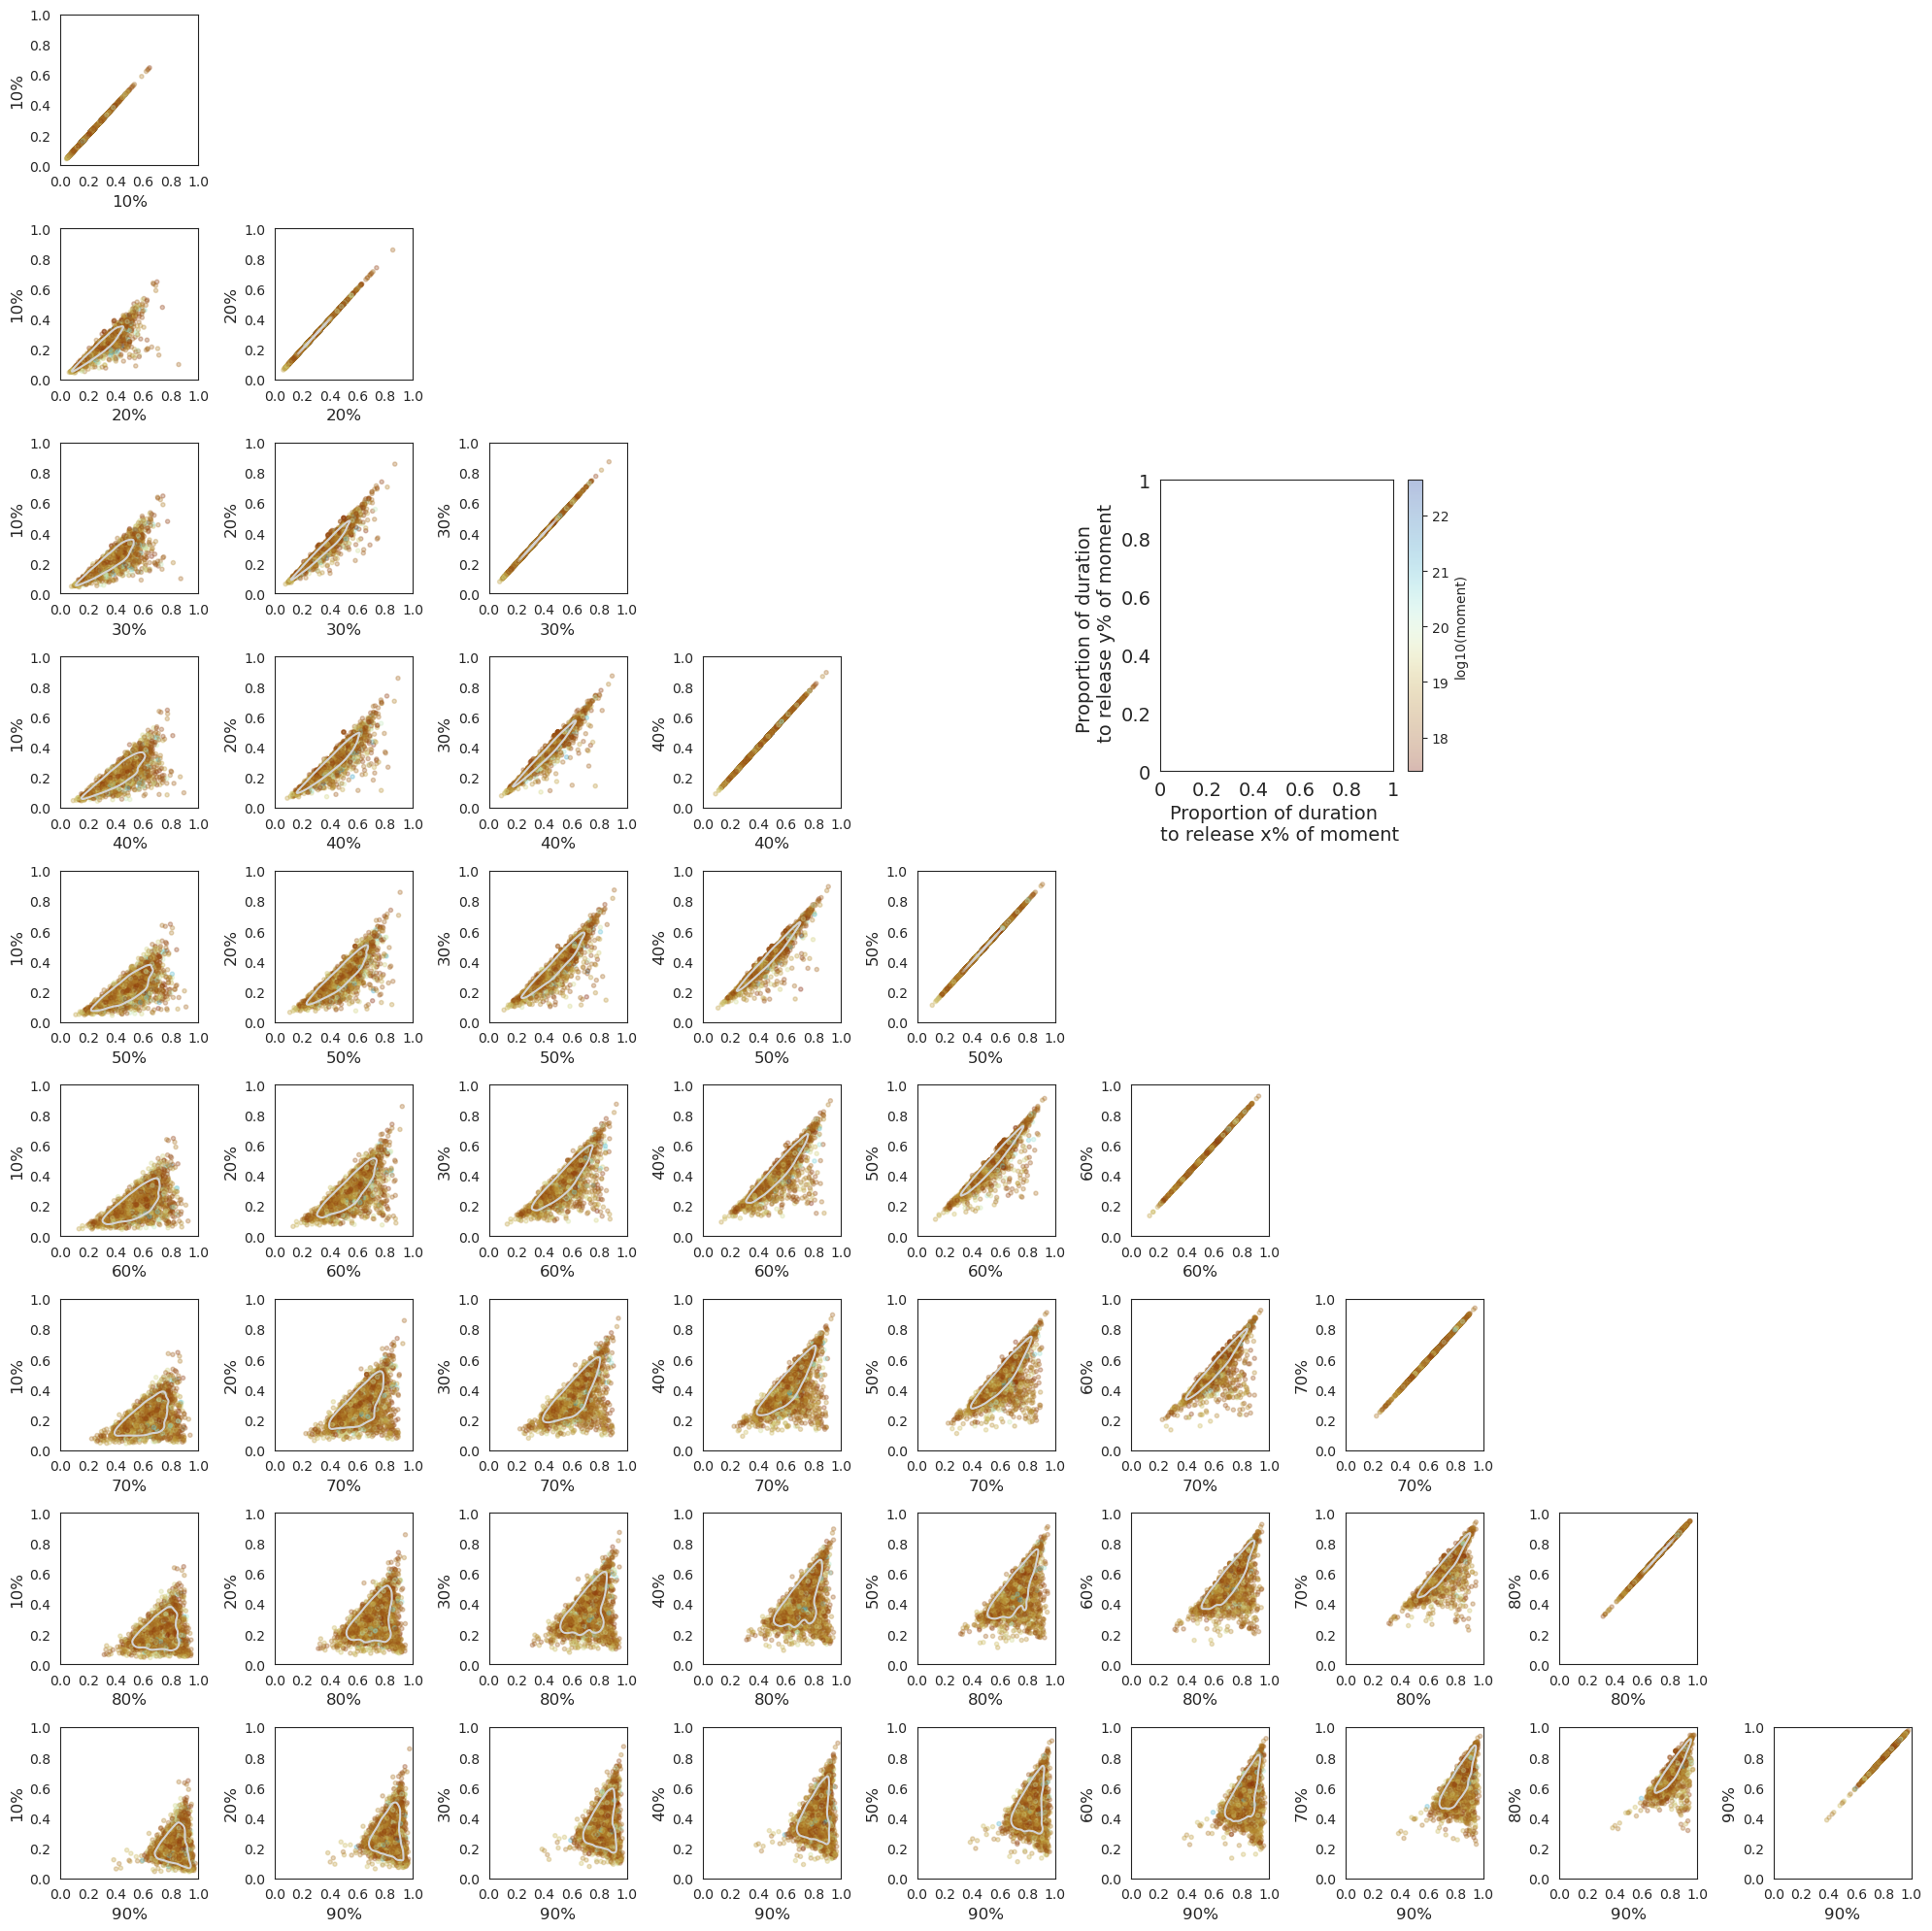

In [ ]:
fig, axs = plt.subplots(len(proportions_list), len(proportions_list), figsize = (20,20))

proportions_list = np.array(proportions_list)
all_relative_root_times = np.array(all_relative_root_times)
all_durations = np.array(all_durations)
all_moments = np.array(all_moments)

for i, x_prop in enumerate(proportions_list):
    for j, y_prop in enumerate(proportions_list):
        if i >= j:
            sc = axs[i][j].scatter(all_relative_root_times[i]/all_durations[i],
                              all_relative_root_times[j]/all_durations[j],
                              alpha = 0.3,
                              marker = '.',
                              c = np.log10(all_moments[i]),
                              cmap = cmc.roma)
            axs[i][j].set_xlabel(f'{x_prop*100:.0f}%', fontsize = 12)
            axs[i][j].set_ylabel(f'{y_prop*100:.0f}%', fontsize = 12)
            axs[i][j].set_xlim(0, 1)
            axs[i][j].set_ylim(0, 1)
            axs[i][j].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            axs[i][j].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            sns.kdeplot(x=all_relative_root_times[i]/all_durations[i],
                        y=all_relative_root_times[j]/all_durations[j],
                        ax = axs[i][j], warn_singular=False,
                        levels = [0.2], fill=None, color = 'lightgrey')

        else:
            axs[i][j].axis('off')

plt.tight_layout()
left, bottom, width, height = [0.6, 0.6, 0.15, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.set_xlabel('Proportion of duration \n to release x% of moment', fontsize = 14)
ax2.set_ylabel('Proportion of duration \n to release y% of moment', fontsize = 14)

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0', '0.2', '0.4','0.6', '0.8', '1'], fontsize = 14)

fig.colorbar(sc, ax = ax2, label = 'log10(moment)', orientation = 'vertical')

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals_comparisons/relative_root_times_contours.png')

In [ ]:
i = 5
j = 5


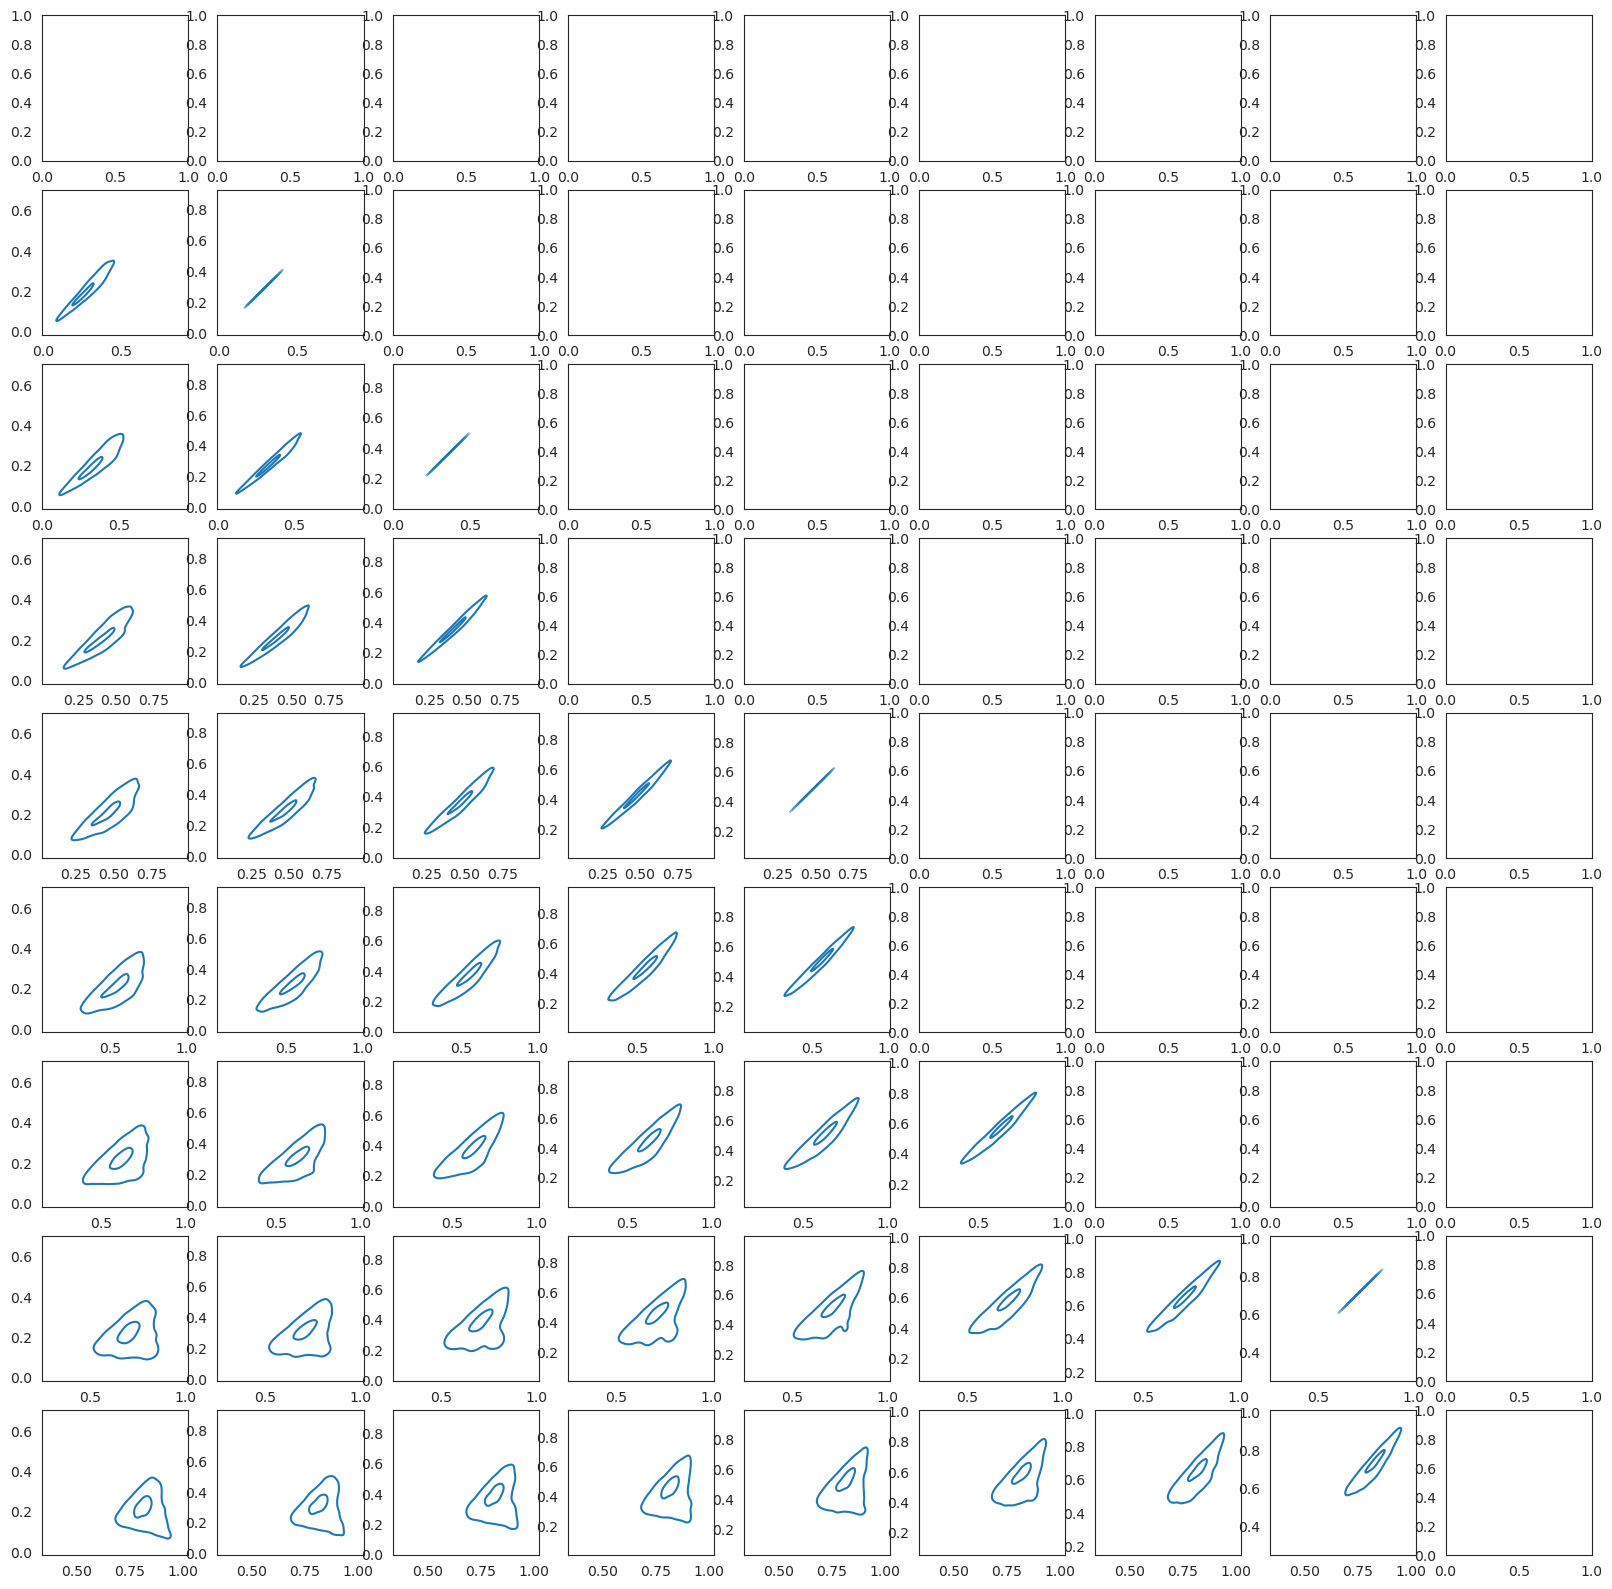

In [ ]:
fig, axs = plt.subplots(len(proportions_list), len(proportions_list), figsize = (20,20))

for i in range(0, len(proportions_list)):
    for j in range(0, len(proportions_list)):
        if i >= j:
            sns.set_style("white")
            sns.kdeplot(x=all_relative_root_times[i]/all_durations[i],
                        y=all_relative_root_times[j]/all_durations[j],
                        ax = axs[i][j], warn_singular=False,
                        levels = [0.2, 0.8])
plt.show()